In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import sys

from smyleutils import averaging_utils as avg
from smyleutils import qboplot_utils as qbo
from smyleutils import colorbar_utils as cbars
from smyleutils import bootstrap_utils as boot
from smyleutils import mapplot_utils as mymaps
from smyleutils import zmplot_utils as zmplot
from smyleutils import linfit_utils as linfit
import cartopy.crs as ccrs
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [3]:
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

### Read in the QBO data

In [4]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init11.nc').Uzm
uzm_era5_nov_tr = avg.cosweightlat(uzm_era5_nov,-5,5).load()
uqbo = uzm_era5_nov_tr.interp(level=60.).sel(time=slice("1970-12-01","1971-02-28")).mean('time')
uqbo = uqbo - uqbo.mean('init_year')
uqbo_std = uqbo.std('init_year')

DataArrayWeighted with weights along dimensions: lat


### Read in the upper tropospheric zonal wind

In [5]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/U_400_100_avg/"
era5_ut = xr.open_dataset(basepath+'U_400_100_avg_ERA5_init11.nc').__xarray_dataarray_variable__
l83_ut = xr.open_dataset(basepath+'U_400_100_avg_L83_init11.nc').__xarray_dataarray_variable__
l32_ut = xr.open_dataset(basepath+'U_400_100_avg_L32_init11.nc').__xarray_dataarray_variable__

# Making sure there are no inconsistences at high decimal points in the lon and lat
l83_ut['lon'] = era5_ut.lon ; l83_ut['lat'] = era5_ut.lat
l32_ut['lon'] = era5_ut.lon ; l32_ut['lat'] = era5_ut.lat

### Read in the Pacific zonal means

In [6]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/pacific_zmU/"
l83_zm = xr.open_dataset(basepath+'U_pacific_L83_init11.nc').U
l83_zm['pre'] = l83_zm.pre / 100.
l32_zm = xr.open_dataset(basepath+'U_pacific_L32_init11.nc').U
l32_zm['pre'] = l32_zm.pre / 100.
era5_zm = xr.open_dataset(basepath+'U_pacific_ERA5_init11.nc').ua
jra3q_zm = xr.open_dataset(basepath+'U_pacific_JRA3Q_init11.nc').ua

# interpolate jra3q onto the same latitude grid as the other datasets
jra3q_zm = jra3q_zm.interp(lat=l83_zm.lat)

# interpolate ERA5 and JRA3Q onto the same pressure levels as the model
jra3q_zm = jra3q_zm.interp(pre=l83_zm.pre)
era5_zm = era5_zm.interp(pre=l83_zm.pre)

# makes sure lats are consistent
era5_zm['lat'] = l83_zm.lat
l32_zm['lat'] = l83_zm.lat

### Calculate the DJF average

In [7]:
era5_ut_djf = era5_ut.sel(time=slice("1970-12-01","1971-03-31")).mean('time')
l83_ut_djf = l83_ut.sel(time=slice("1970-12-01","1971-03-31")).mean('time')
l32_ut_djf = l32_ut.sel(time=slice("1970-12-01","1971-03-31")).mean('time')

era5_zm_djf = era5_zm.sel(time=slice("1970-12-01","1971-03-31")).mean('time')
l83_zm_djf = l83_zm.sel(time=slice("1970-12-01","1971-03-31")).mean('time')
l32_zm_djf = l32_zm.sel(time=slice("1970-12-01","1971-03-31")).mean('time')

### Calculate the ensemble mean

In [8]:
l83_ut_djf_em = l83_ut_djf.mean('M').load()
l32_ut_djf_em = l32_ut_djf.mean('M').load()
era5_ut_djf = era5_ut_djf.load()

l83_zm_djf_em = l83_zm_djf.mean('M').load()
l32_zm_djf_em = l32_zm_djf.mean('M').load()
era5_zm_djf = era5_zm_djf.load()

In [9]:
l83_ut_djf_em = l83_ut_djf_em.chunk({'init_year':51, 'lat':100, 'lon':100})
l32_ut_djf_em = l32_ut_djf_em.chunk({'init_year':51, 'lat':100, 'lon':100})
era5_ut_djf = era5_ut_djf.chunk({'init_year':51, 'lat':100, 'lon':100})

### Calculate the lead dependent climatology

In [10]:
era5_ut_djf_clim = era5_ut_djf.mean('init_year')
l83_ut_djf_clim = l83_ut_djf_em.mean('init_year')
l32_ut_djf_clim = l32_ut_djf_em.mean('init_year')

era5_zm_djf_clim = era5_zm_djf.mean('init_year')
l83_zm_djf_clim = l83_zm_djf_em.mean('init_year')
l32_zm_djf_clim = l32_zm_djf_em.mean('init_year')

### Remove the lead dependent climatology

In [11]:
era5_ut_djf_anoms = era5_ut_djf - era5_ut_djf_clim
l83_ut_djf_anoms = l83_ut_djf_em - l83_ut_djf_clim
l32_ut_djf_anoms = l32_ut_djf_em - l32_ut_djf_clim

era5_zm_djf_anoms = era5_zm_djf - era5_zm_djf_clim
l83_zm_djf_anoms = l83_zm_djf_em - l83_zm_djf_clim
l32_zm_djf_anoms = l32_zm_djf_em - l32_zm_djf_clim

### Regress out ENSO or not

In [12]:
sst = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SST/SST_ERSSTv5_mon_init11.nc")
sstm = sst.sel(time=slice("1970-11-01","1971-03-31")).mean('time')
nino34 = avg.cosweightlonlat(sstm, 210, 270, -5, 5)
nino34 = nino34.ssta - nino34.ssta.mean('init_year')

a_era5_zm = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])
b_era5_zm = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])

a_l83_zm = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])
b_l83_zm = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])

a_l32_zm = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])
b_l32_zm = xr.DataArray(np.zeros([era5_zm_djf_anoms.pre.size, era5_zm_djf_anoms.lat.size]), dims=['pre','lat'], 
                                coords=[era5_zm_djf_anoms.pre, era5_zm_djf_anoms.lat])

a_era5_ut = xr.DataArray(np.zeros([era5_ut_djf_anoms.lat.size, era5_ut_djf_anoms.lon.size]), dims=['lat','lon'], 
                                coords=[era5_ut_djf_anoms.lat, era5_ut_djf_anoms.lon])
b_era5_ut = xr.DataArray(np.zeros([era5_ut_djf_anoms.lat.size, era5_ut_djf_anoms.lon.size]), dims=['lat','lon'], 
                                coords=[era5_ut_djf_anoms.lat, era5_ut_djf_anoms.lon])

a_l83_ut = xr.DataArray(np.zeros([era5_ut_djf_anoms.lat.size, era5_ut_djf_anoms.lon.size]), dims=['lat','lon'], 
                                coords=[era5_ut_djf_anoms.lat, era5_ut_djf_anoms.lon])
b_l83_ut = xr.DataArray(np.zeros([era5_ut_djf_anoms.lat.size, era5_ut_djf_anoms.lon.size]), dims=['lat','lon'], 
                                coords=[era5_ut_djf_anoms.lat, era5_ut_djf_anoms.lon])

a_l32_ut = xr.DataArray(np.zeros([era5_ut_djf_anoms.lat.size, era5_ut_djf_anoms.lon.size]), dims=['lat','lon'], 
                                coords=[era5_ut_djf_anoms.lat, era5_ut_djf_anoms.lon])
b_l32_ut = xr.DataArray(np.zeros([era5_ut_djf_anoms.lat.size, era5_ut_djf_anoms.lon.size]), dims=['lat','lon'], 
                                coords=[era5_ut_djf_anoms.lat, era5_ut_djf_anoms.lon])

for ilat in np.arange(0,era5_zm_djf_anoms.lat.size,1):
    for ilon in np.arange(0,era5_ut_djf_anoms.lon.size,1):
        at, bt = linfit.linfit_xy(nino34, era5_ut_djf_anoms.isel(lon=ilon, lat=ilat))
        a_era5_ut[ilat,ilon] = at ; b_era5_ut[ilat,ilon] = bt

        at, bt = linfit.linfit_xy(nino34, l83_ut_djf_anoms.isel(lon=ilon, lat=ilat))
        a_l83_ut[ilat,ilon] = at ; b_l83_ut[ilat,ilon] = bt

        at, bt = linfit.linfit_xy(nino34, l32_ut_djf_anoms.isel(lon=ilon, lat=ilat))
        a_l32_ut[ilat,ilon] = at ; b_l32_ut[ilat,ilon] = bt

    for ip in np.arange(0,era5_zm_djf_anoms.pre.size,1):
        at, bt = linfit.linfit_xy(nino34, era5_zm_djf_anoms.isel(pre=ip, lat=ilat))
        a_era5_zm[ip,ilat] = at ; b_era5_zm[ip,ilat] = bt

        at, bt = linfit.linfit_xy(nino34, l83_zm_djf_anoms.isel(pre=ip, lat=ilat))
        a_l83_zm[ip,ilat] = at ; b_l83_zm[ip,ilat] = bt

        at, bt = linfit.linfit_xy(nino34, l32_zm_djf_anoms.isel(pre=ip, lat=ilat))
        a_l32_zm[ip,ilat] = at ; b_l32_zm[ip,ilat] = bt

In [13]:
era5_zm_withenso = era5_zm_djf_anoms
era5_zm_noenso = era5_zm_djf_anoms - (a_era5_zm + b_era5_zm*nino34)

l83_zm_withenso = l83_zm_djf_anoms
l83_zm_noenso = l83_zm_djf_anoms - (a_l83_zm + b_l83_zm*nino34)

l32_zm_withenso = l32_zm_djf_anoms
l32_zm_noenso = l32_zm_djf_anoms - (a_l32_zm + b_l32_zm*nino34)

era5_ut_withenso = era5_ut_djf_anoms
era5_ut_noenso = era5_ut_djf_anoms - (a_era5_ut + b_era5_ut*nino34)

l83_ut_withenso = l83_ut_djf_anoms
l83_ut_noenso = l83_ut_djf_anoms - (a_l83_ut + b_l83_ut*nino34)

l32_ut_withenso = l32_ut_djf_anoms
l32_ut_noenso = l32_ut_djf_anoms - (a_l32_ut + b_l32_ut*nino34)


### Get the westerly and easterly QBO composites

In [14]:
westera5_ut_withenso = era5_ut_withenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastera5_ut_withenso = era5_ut_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westera5_ut_noenso = era5_ut_noenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastera5_ut_noenso = era5_ut_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl83_ut_withenso = l83_ut_withenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl83_ut_withenso = l83_ut_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl83_ut_noenso = l83_ut_noenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl83_ut_noenso = l83_ut_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl32_ut_withenso = l32_ut_withenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl32_ut_withenso = l32_ut_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl32_ut_noenso = l32_ut_noenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl32_ut_noenso = l32_ut_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()


westera5_zm_withenso = era5_zm_withenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastera5_zm_withenso = era5_zm_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westera5_zm_noenso = era5_zm_noenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastera5_zm_noenso = era5_zm_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl83_zm_withenso = l83_zm_withenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl83_zm_withenso = l83_zm_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl83_zm_noenso = l83_zm_noenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl83_zm_noenso = l83_zm_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl32_zm_withenso = l32_zm_withenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl32_zm_withenso = l32_zm_withenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

westl32_zm_noenso = l32_zm_noenso.isel(init_year = uqbo.values > uqbo_std.values).load()
eastl32_zm_noenso = l32_zm_noenso.isel(init_year = uqbo.values < -1.*uqbo_std.values).load()

### Read in significance data calculated at ~/DATA_SORT/SIGNIF/fig11

In [15]:
signifdat = xr.open_dataset("/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/SIGNIF/fig11/signif_qbo_composites.nc")

In [16]:
import warnings
warnings.filterwarnings('ignore')

### Plot with ENSO included - not saving this one

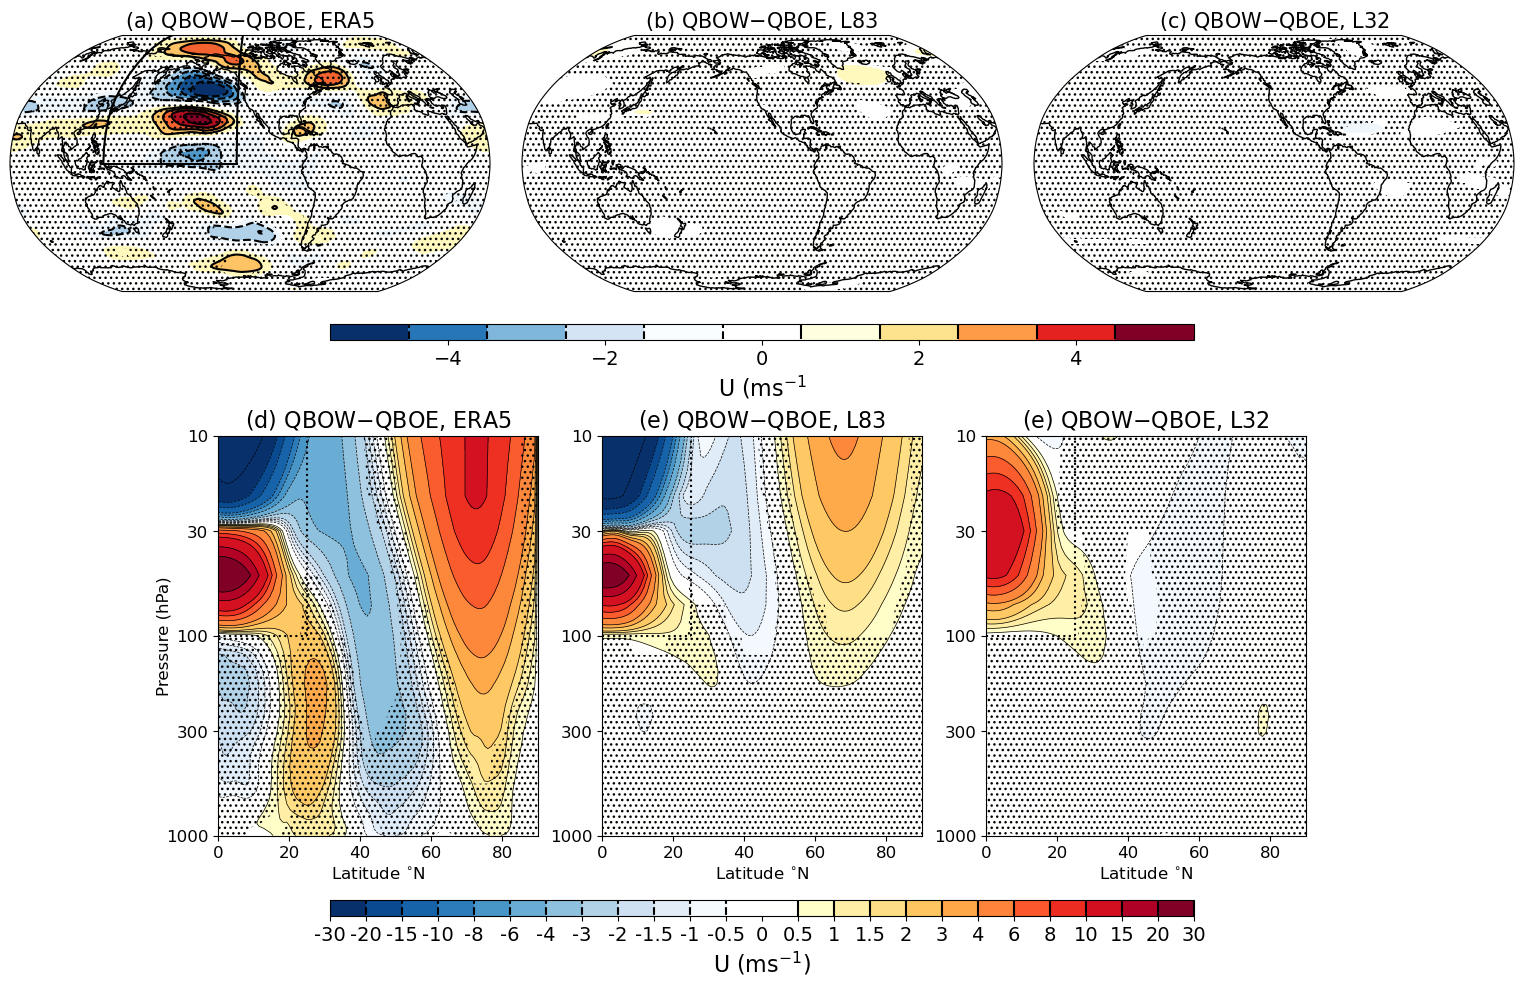

In [17]:
fig = plt.figure(figsize=(16,16))

dif = westera5_ut_withenso.mean('init_year') - eastera5_ut_withenso.mean('init_year')
signifplot = signifdat.signif_era5_ut_withenso
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, dif.isel(lat=slice(1,dif.lat.size-2)), dif.lon, dif.lat.isel(lat=slice(1,dif.lat.size-2)), 
                                               1, -5, 5, '(a) QBOW$-$QBOE, ERA5',0.05,0.35,0.36,0.52, contourlines=True, 
                                               signifdat = signifplot.isel(lat=slice(1,dif.lat.size-2)), stipplesignif=True)
ax.plot([130,130],[0,90], transform=ccrs.PlateCarree(), color='black')
ax.plot([230,230],[0,90], transform=ccrs.PlateCarree(), color='black')
ax.plot([130,230],[0,0], transform=ccrs.PlateCarree(), color='black')

dif = westl83_ut_withenso.mean('init_year') - eastl83_ut_withenso.mean('init_year')
signifplot = signifdat.signif_l83_ut_withenso
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, dif.isel(lat=slice(1,dif.lat.size-2)), dif.lon, dif.lat.isel(lat=slice(1,dif.lat.size-2)), 
                                               1, -5, 5, '(b) QBOW$-$QBOE, L83',0.37,0.67,0.36,0.52, contourlines=True,
                                              signifdat = signifplot.isel(lat=slice(1,dif.lat.size-2)), stipplesignif=True)

dif = westl32_ut_withenso.mean('init_year') - eastl32_ut_withenso.mean('init_year')
signifplot = signifdat.signif_l32_ut_withenso
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, dif.isel(lat=slice(1,dif.lat.size-2)), dif.lon, dif.lat.isel(lat=slice(1,dif.lat.size-2)), 
                                               1, -5, 5, '(c) QBOW$-$QBOE, L32',0.69,0.99,0.36,0.52, contourlines=True,
                                              signifdat = signifplot.isel(lat=slice(1,dif.lat.size-2)), stipplesignif=True)

ax = cbars.plotcolorbar(fig, 1, -5, 5, 'U (ms$^{-1}$', 0.25,0.79,0.33,0.34, contourlines=True)

clevs=np.array([-30,-20,-15,-10.,-8.,-6,-4,-3,-2.,-1.5,-1,-0.5,0.,0.5,1.,1.5,2.,3,4,6.,8,10.,15,20,30])

dif = westera5_zm_withenso.mean('init_year') - eastera5_zm_withenso.mean('init_year')
signifplot = signifdat.signif_era5_zm_withenso

ax = zmplot.plotlatlogpre_nh_1000_10(fig, dif, dif.lat, dif.pre, 0.5,-5,5,'(d) QBOW$-$QBOE, ERA5',
                             0.18,0.38,0.02,0.27, speclevs=clevs, signifdat = signifplot, stipplesignif=True)
ax.plot([0,25],[-np.log10(100),-np.log10(100)], color='black', linestyle='dotted')
ax.plot([25,25],[-np.log10(100),-np.log10(10)], color='black', linestyle='dotted')

dif = westl83_zm_withenso.mean('init_year') - eastl83_zm_withenso.mean('init_year')
signifplot = signifdat.signif_l83_zm_withenso
ax = zmplot.plotlatlogpre_nh_1000_10(fig, dif, dif.lat, dif.pre, 0.5, -5, 5, '(e) QBOW$-$QBOE, L83',
                                     0.42,0.62,0.02,0.27, speclevs=clevs, signifdat=signifplot, stipplesignif=True, ylabel=False)
ax.plot([0,25],[-np.log10(100),-np.log10(100)], color='black', linestyle='dotted')
ax.plot([25,25],[-np.log10(100),-np.log10(10)], color='black', linestyle='dotted')


dif = westl32_zm_withenso.mean('init_year') - eastl32_zm_withenso.mean('init_year')
signifplot = signifdat.signif_l32_zm_withenso
ax = zmplot.plotlatlogpre_nh_1000_10(fig, dif, dif.lat, dif.pre, 0.5, -5, 5, '(e) QBOW$-$QBOE, L32',
                                     0.66,0.86,0.02,0.27, speclevs=clevs, signifdat=signifplot, stipplesignif=True, ylabel=False)
ax.plot([0,25],[-np.log10(100),-np.log10(100)], color='black', linestyle='dotted')
ax.plot([25,25],[-np.log10(100),-np.log10(10)], color='black', linestyle='dotted')

ax = cbars.plotcolorbar_sayc(fig, clevs, 'U (ms$^{-1}$)', 0.25,0.79,-0.03,-0.02, contourlines=True,
                            ticks=clevs,
                             ticklabels=['-30','-20','-15','-10','-8','-6','-4','-3','-2','-1.5','-1','-0.5','0',
                                         '0.5','1','1.5','2','3','4','6','8','10','15','20','30'])

#fig.savefig(plotpath+'fig11.png', bbox_inches='tight', facecolor='white')

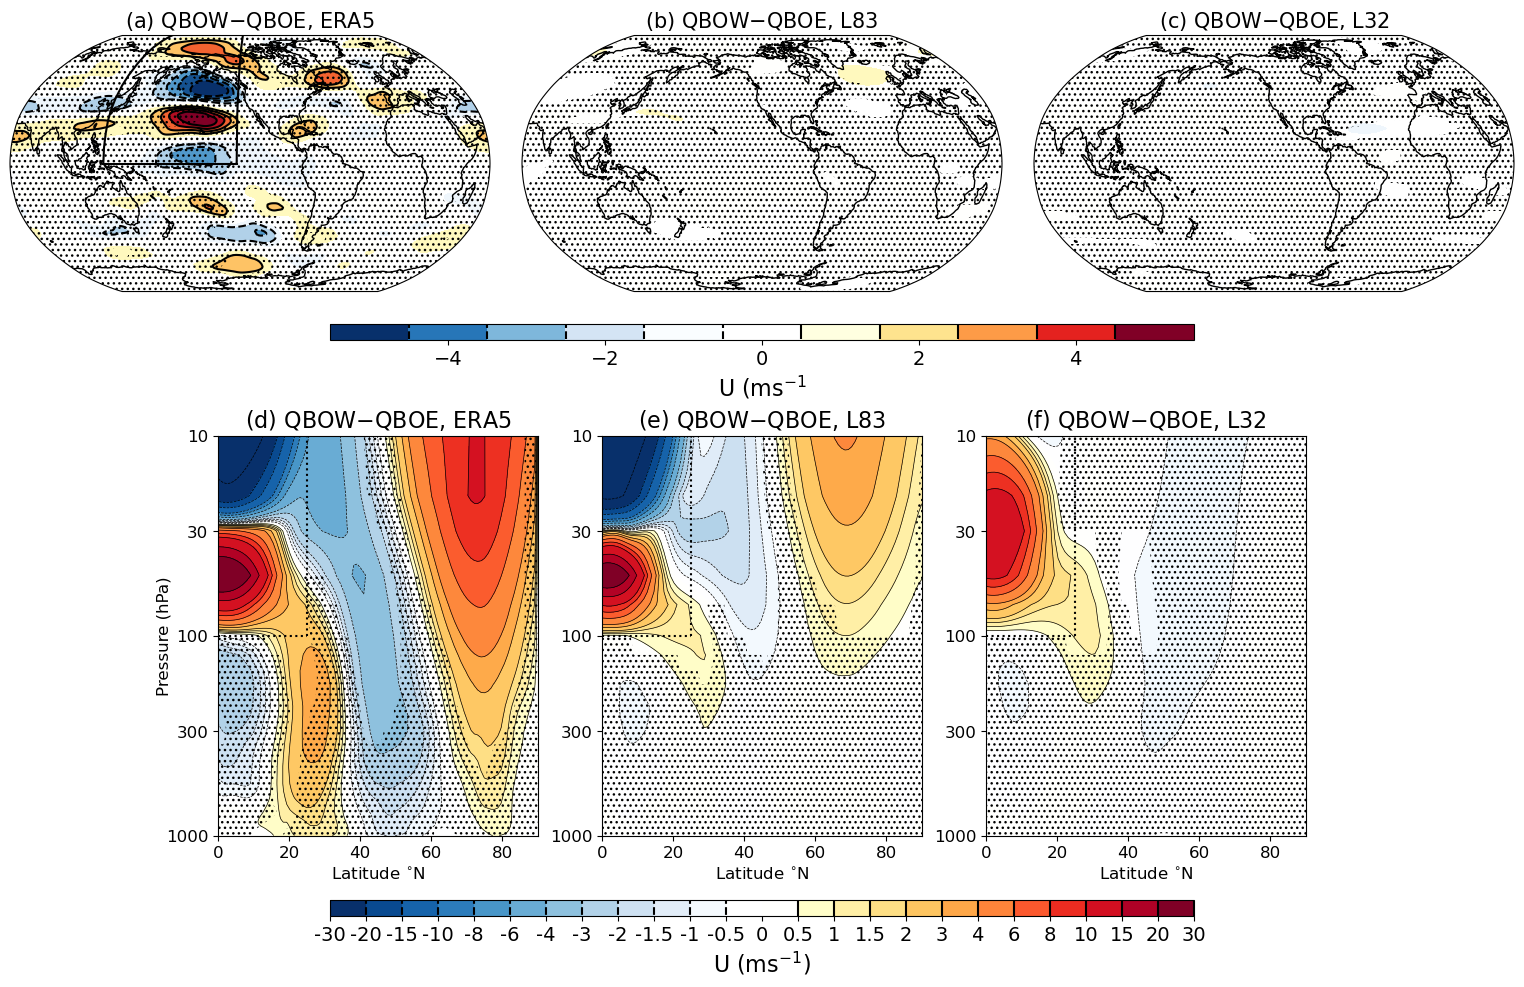

In [19]:
fig = plt.figure(figsize=(16,16))

dif = westera5_ut_noenso.mean('init_year') - eastera5_ut_noenso.mean('init_year')
signifplot = signifdat.signif_era5_ut_noenso
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, dif.isel(lat=slice(1,dif.lat.size-2)), dif.lon, dif.lat.isel(lat=slice(1,dif.lat.size-2)), 
                                               1, -5, 5, '(a) QBOW$-$QBOE, ERA5',0.05,0.35,0.36,0.52, contourlines=True, 
                                               signifdat = signifplot.isel(lat=slice(1,dif.lat.size-2)), stipplesignif=True)
ax.plot([130,130],[0,90], transform=ccrs.PlateCarree(), color='black')
ax.plot([230,230],[0,90], transform=ccrs.PlateCarree(), color='black')
ax.plot([130,230],[0,0], transform=ccrs.PlateCarree(), color='black')

dif = westl83_ut_noenso.mean('init_year') - eastl83_ut_noenso.mean('init_year')
signifplot = signifdat.signif_l83_ut_noenso
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, dif.isel(lat=slice(1,dif.lat.size-2)), dif.lon, dif.lat.isel(lat=slice(1,dif.lat.size-2)), 
                                               1, -5, 5, '(b) QBOW$-$QBOE, L83',0.37,0.67,0.36,0.52, contourlines=True,
                                              signifdat = signifplot.isel(lat=slice(1,dif.lat.size-2)), stipplesignif=True)

dif = westl32_ut_noenso.mean('init_year') - eastl32_ut_noenso.mean('init_year')
signifplot = signifdat.signif_l32_ut_noenso
ax = mymaps.contourmap_bothoceans_robinson_pos(fig, dif.isel(lat=slice(1,dif.lat.size-2)), dif.lon, dif.lat.isel(lat=slice(1,dif.lat.size-2)), 
                                               1, -5, 5, '(c) QBOW$-$QBOE, L32',0.69,0.99,0.36,0.52, contourlines=True,
                                              signifdat = signifplot.isel(lat=slice(1,dif.lat.size-2)), stipplesignif=True)

ax = cbars.plotcolorbar(fig, 1, -5, 5, 'U (ms$^{-1}$', 0.25,0.79,0.33,0.34, contourlines=True)

clevs=np.array([-30,-20,-15,-10.,-8.,-6,-4,-3,-2.,-1.5,-1,-0.5,0.,0.5,1.,1.5,2.,3,4,6.,8,10.,15,20,30])

dif = westera5_zm_noenso.mean('init_year') - eastera5_zm_noenso.mean('init_year')
signifplot = signifdat.signif_era5_zm_noenso

ax = zmplot.plotlatlogpre_nh_1000_10(fig, dif, dif.lat, dif.pre, 0.5,-5,5,'(d) QBOW$-$QBOE, ERA5',
                             0.18,0.38,0.02,0.27, speclevs=clevs, signifdat = signifplot, stipplesignif=True)
ax.plot([0,25],[-np.log10(100),-np.log10(100)], color='black', linestyle='dotted')
ax.plot([25,25],[-np.log10(100),-np.log10(10)], color='black', linestyle='dotted')

dif = westl83_zm_noenso.mean('init_year') - eastl83_zm_noenso.mean('init_year')
signifplot = signifdat.signif_l83_zm_noenso
ax = zmplot.plotlatlogpre_nh_1000_10(fig, dif, dif.lat, dif.pre, 0.5, -5, 5, '(e) QBOW$-$QBOE, L83',
                                     0.42,0.62,0.02,0.27, speclevs=clevs, signifdat=signifplot, stipplesignif=True, ylabel=False)
ax.plot([0,25],[-np.log10(100),-np.log10(100)], color='black', linestyle='dotted')
ax.plot([25,25],[-np.log10(100),-np.log10(10)], color='black', linestyle='dotted')


dif = westl32_zm_noenso.mean('init_year') - eastl32_zm_noenso.mean('init_year')
signifplot = signifdat.signif_l32_zm_noenso
ax = zmplot.plotlatlogpre_nh_1000_10(fig, dif, dif.lat, dif.pre, 0.5, -5, 5, '(f) QBOW$-$QBOE, L32',
                                     0.66,0.86,0.02,0.27, speclevs=clevs, signifdat=signifplot, stipplesignif=True, ylabel=False)
ax.plot([0,25],[-np.log10(100),-np.log10(100)], color='black', linestyle='dotted')
ax.plot([25,25],[-np.log10(100),-np.log10(10)], color='black', linestyle='dotted')

ax = cbars.plotcolorbar_sayc(fig, clevs, 'U (ms$^{-1}$)', 0.25,0.79,-0.03,-0.02, contourlines=True,
                            ticks=clevs,
                             ticklabels=['-30','-20','-15','-10','-8','-6','-4','-3','-2','-1.5','-1','-0.5','0',
                                         '0.5','1','1.5','2','3','4','6','8','10','15','20','30'])

fig.savefig(plotpath+'fig11.png', bbox_inches='tight', facecolor='white')